# Multivariate to each input/output Time Series

In [1]:
import numpy as np
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
# https://www.gritfeat.com/explainable-aixai-from-correlation-to-causation-shap-for-lstm-time-series-model/
#http://localhost:8888/lab/tree/MyQuantFinProject/TimeSeriesML-FinMarket/Nachiketa-Hebbar-LSTM/RNN_Youtube.ipynb

In [10]:
ab_path = "../data/SPY-Daily-Y09-Now.csv"
stockname='S&P500'
start_date='2016-01-01'
end_date='2022-12-31'

prediction_col='Price'
my_features=['Price', 'EMA1','EMA2','EMA3','MACD', 'SIGNAL', 'RSI','RSI-MA']
# each feature predict itself



train_ratio=0.9

# define generator
n_input =33
n_features = len(my_features)
print(f"input={n_input} and features={n_features}")

input=33 and features=8


# Load Data

In [11]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':'Date'},inplace=True)
allCols=list(df.columns)
print(allCols)

df['Date']=df['Date'].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index('Date',inplace=True)
df=df.loc[start_date:end_date][my_features]
print(df.info())
print(df.tail(3))



['Ticker', 'Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1755 entries, 2016-01-04 to 2022-12-20
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1755 non-null   float64
 1   EMA1    1755 non-null   float64
 2   EMA2    1755 non-null   float64
 3   EMA3    1755 non-null   float64
 4   MACD    1755 non-null   float64
 5   SIGNAL  1755 non-null   float64
 6   RSI     1755 non-null   float64
 7   RSI-MA  1755 non-null   float64
dtypes: float64(8)
memory usage: 123.4 KB
None
             Price    EMA1    EMA2    EMA3  MACD  SIGNAL    RSI  RSI-MA
Date                                                                   
2022-12-16  383.27  394.41  394.82  394.82 -0.40    2.36  41.91   50.77
2022-12-19  380.02  391.80  393.41  393.41 -1.61    1.86  39.86   47.83
2022-12-20  380.54  389.75  392.18  392.18 -2.43    1.32  40.36   44.55


# Tranform Data

In [12]:
print("Tranform Data")
dfValues=df.values
print(dfValues.shape)
train_data_len = math.ceil(len(dfValues) * train_ratio)
print(f"{train_ratio} of {len(dfValues)} = The number of train data is {train_data_len}")
train_values = dfValues[0:train_data_len]
test_values = dfValues[train_data_len:]
print(train_values.shape,test_values.shape)
    
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
scaler = MinMaxScaler()
#scaler= PowerTransformer()
scaler.fit(train_values)
train = scaler.transform(train_values)
test = scaler.transform(test_values)

print(train.shape,test.shape)
print(type(train),type(test))
print(train[-2:])
print(test[-2:])

Tranform Data
(1755, 8)
0.9 of 1755 = The number of train data is 1580
(1580, 8) (175, 8)
(1580, 8) (175, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[0.89777853 0.91610317 0.9169806  0.9169806  0.82170819 0.86807258
  0.48317095 0.47272411]
 [0.87183314 0.9097595  0.91449286 0.91449286 0.78185053 0.85924473
  0.39961618 0.42720639]]
[[0.66867899 0.71352388 0.72563793 0.72563793 0.66939502 0.81216282
  0.31104222 0.37213343]
 [0.6704426  0.70637853 0.72126661 0.72126661 0.64021352 0.78567925
  0.31842338 0.31514941]]


# Generate Timeseries For LSTM

In [13]:
# each feature predict itself
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
n_output=len(my_features)

# each feature predict one output , 0=close is targer 
# generator = TimeseriesGenerator(train,train[:,0], length=n_input, batch_size=1)
# n_output=1

# number of samples
print(f'Samples: {len(generator)}')
# print each sample
for i in range(len(generator)):
 x, y = generator[i]
 if i<=1:
    # n_output=y.shape[1]
    # print("Output: ",n_output)
    print(x.shape,y.shape)  
    print(f'{x} => {y}')
    print("=========================")
    


Samples: 1547
(1, 33, 8) (1, 8)
[[[6.15906393e-02 6.01603346e-02 5.60096666e-02 5.60096666e-02
   7.03914591e-01 6.98871996e-01 3.41895483e-01 3.81341209e-01]
  [6.27437680e-02 5.82781457e-02 5.47657971e-02 5.47657971e-02
   6.96797153e-01 6.96419814e-01 3.52819604e-01 3.58408617e-01]
  [5.41292182e-02 5.51063088e-02 5.28111451e-02 5.28111451e-02
   6.84341637e-01 6.92005885e-01 2.94508415e-01 3.07505212e-01]
  [3.79515008e-02 4.94945974e-02 4.93993887e-02 4.93993887e-02
   6.61209964e-01 6.84649338e-01 2.04901092e-01 2.45482974e-01]
  [3.07274886e-02 4.35691879e-02 4.56322411e-02 4.56322411e-02
   6.38434164e-01 6.73859735e-01 1.71095365e-01 1.89020153e-01]
  [3.13718840e-02 3.88288602e-02 4.22560239e-02 4.22560239e-02
   6.23843416e-01 6.62089259e-01 1.78033658e-01 1.50451703e-01]
  [3.66287943e-02 3.59358662e-02 3.97327458e-02 3.97327458e-02
   6.19572954e-01 6.50809220e-01 2.33835252e-01 1.22307158e-01]
  [2.02475835e-02 3.04984315e-02 3.57879025e-02 3.57879025e-02
   6.03558719e-0

# LSTM Train

In [14]:
#neuron_number=100

np.random.seed(7)
neuron_number=n_input* n_features
print(f"{neuron_number}= {n_input} x {n_features} (univariate n_features=1)")

model = Sequential()

model.add(LSTM(neuron_number, activation='relu',return_sequences=False, input_shape=(n_input, n_features)))  

model.add(Dense(n_output))

#https://keras.io/api/metrics/
# model.compile(optimizer="adam", loss="mean_squared_error")
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

264= 33 x 8 (univariate n_features=1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 264)               288288    
                                                                 
 dense_1 (Dense)             (None, 8)                 2120      
                                                                 
Total params: 290,408
Trainable params: 290,408
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#history=model.fit_generator(generator, steps_per_epoch=1, epochs=n_epochs, verbose=0)
history=model.fit(generator,epochs=100,batch_size=48,shuffle=False)

Epoch 1/100
1547/1547 [==============================] - 55s 35ms/step - loss: 0.0057
Epoch 2/100
1547/1547 [==============================] - 51s 33ms/step - loss: 0.0055
Epoch 3/100
1547/1547 [==============================] - 46s 30ms/step - loss: 0.0042
Epoch 4/100
1547/1547 [==============================] - 47s 30ms/step - loss: 0.0031
Epoch 5/100
1547/1547 [==============================] - 46s 30ms/step - loss: 0.0020
Epoch 6/100
1547/1547 [==============================] - 46s 30ms/step - loss: 0.0017
Epoch 7/100
1547/1547 [==============================] - 48s 31ms/step - loss: 0.0014
Epoch 8/100
1547/1547 [==============================] - 46s 30ms/step - loss: 0.0012
Epoch 9/100
1547/1547 [==============================] - 47s 30ms/step - loss: 0.0012
Epoch 10/100
1547/1547 [==============================] - 48s 31ms/step - loss: 0.0012
Epoch 11/100
1547/1547 [==============================] - 48s 31ms/step - loss: 0.0012
Epoch 12/100
1547/1547 [============================

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

# Get Test Data(Unseen) by include {n_input_lookback} to predict

# Set Test data for prediction

In [114]:
# test_arr will get start with the last n look back to predict
idx_train_to_test=len(dfValues)-len(test_values)-n_input
print("The first train data to predict the frist test :",idx_train_to_test)



The first train data to predict the frist test : 1558


In [115]:
test_arr=dfValues[idx_train_to_test:]
print(f"Get Test Data {len(test_values)} + {n_input} to predict = {test_arr.shape}")
print(test_arr.shape)
test_scaled_arr=scaler.fit_transform(test_arr)
print(test_scaled_arr.shape)
print(test_scaled_arr[:2])


Get Test Data 175 + 22 to predict = (197, 4)
(197, 4)
(197, 4)
[[0.60491475 0.80266872 0.23342939 0.23156046]
 [0.57567387 0.78457788 0.2240634  0.23933768]]


In [116]:
#No.row = len(test_arr)-n_hop_lookback  , we will start triaing at the first rows since n_hop
X_test=[]
for i in range(n_input,test_scaled_arr.shape[0]):
   X_test.append(test_scaled_arr[i-n_input:i]) 
X_test=np.array(X_test)
print(X_test.shape)
print(X_test[:2])

(175, 22, 4)
[[[0.60491475 0.80266872 0.23342939 0.23156046]
  [0.57567387 0.78457788 0.2240634  0.23933768]
  [0.66301553 0.77931742 0.22118156 0.28775715]
  [0.7530241  0.78611753 0.23126801 0.32438535]
  [0.8049338  0.79894791 0.25360231 0.38133467]
  [0.83779408 0.81472928 0.28674352 0.46161565]
  [0.83655586 0.8288427  0.32564841 0.5491721 ]
  [0.88608439 0.84808827 0.370317   0.61741094]
  [0.83093628 0.85835258 0.41354467 0.63472153]
  [0.89465663 0.8758019  0.45821326 0.65579528]
  [0.91561101 0.89427765 0.50432277 0.67310587]
  [0.9462806  0.91493457 0.5518732  0.69969895]
  [1.         0.94046703 0.60158501 0.72604114]
  [0.97285456 0.96009751 0.64913545 0.76141495]
  [0.90561006 0.96933539 0.68659942 0.74962368]
  [0.9178017  0.97908648 0.71685879 0.73557451]
  [0.9547576  0.99281499 0.74279539 0.72503763]
  [0.89979998 0.99807544 0.76080692 0.67636729]
  [0.85684351 0.99743392 0.76873199 0.62318113]
  [0.87827412 0.99948678 0.77089337 0.6063723 ]
  [0.86684446 1.         0.

# Prediction

In [117]:
y_test_scaled_pred=model.predict(X_test)
print("Before Invert :",y_test_scaled_pred.shape)
y_test_scaled_pred[:3]

6/6 [==============================] - 0s 7ms/step
Before Invert : (175, 4)


array([[0.90425384, 0.8928347 , 0.9162976 , 0.43328768],
       [0.9053552 , 0.8926706 , 0.8980293 , 0.39497095],
       [0.9309877 , 0.90606046, 0.89938104, 0.41573536]], dtype=float32)

In [118]:
y_test_pred=scaler.inverse_transform(y_test_scaled_pred)
print("After Invert :" ,y_test_pred.shape)
y_test_pred[:3]

After Invert : (175, 4)


array([[451.49762 , 438.89752 ,   5.068211,  47.730846],
       [451.61328 , 438.88477 ,   4.814647,  46.203545],
       [454.3044  , 439.92834 ,   4.833409,  47.03121 ]], dtype=float32)

# Create Predction DataFrame and Measure and Plot Chart

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        175 non-null    float64
 1   Price-Pred   175 non-null    float32
 2   EMA2         175 non-null    float64
 3   EMA2-Pred    175 non-null    float32
 4   SIGNAL       175 non-null    float64
 5   SIGNAL-Pred  175 non-null    float32
 6   RSI-MA       175 non-null    float64
 7   RSI-MA-Pred  175 non-null    float32
dtypes: float32(4), float64(4)
memory usage: 8.3 KB
None


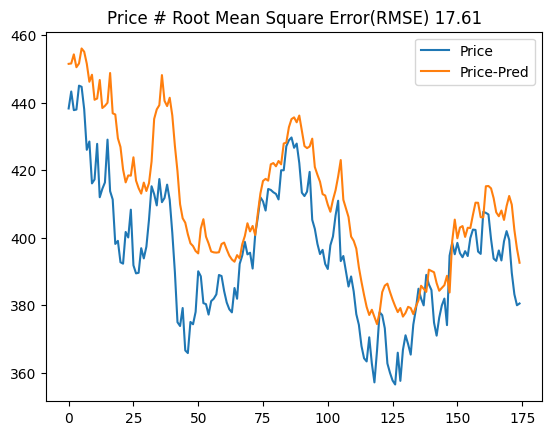

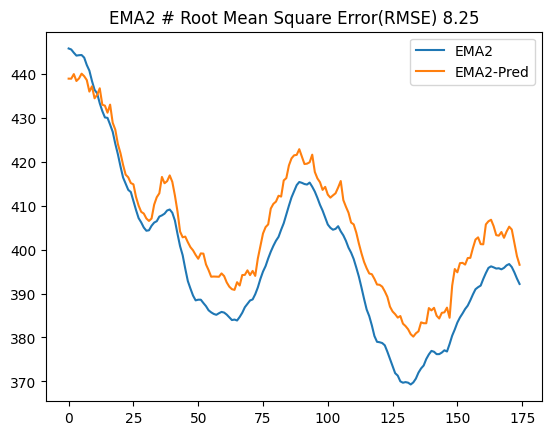

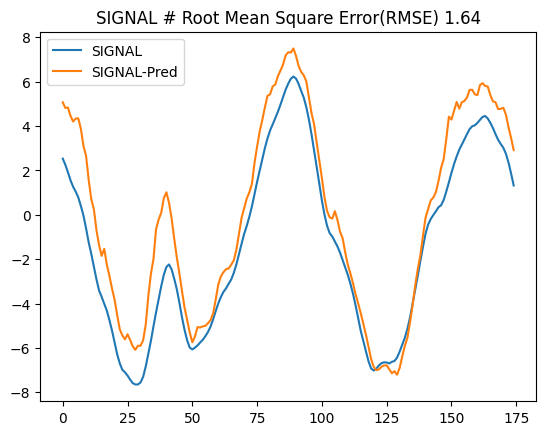

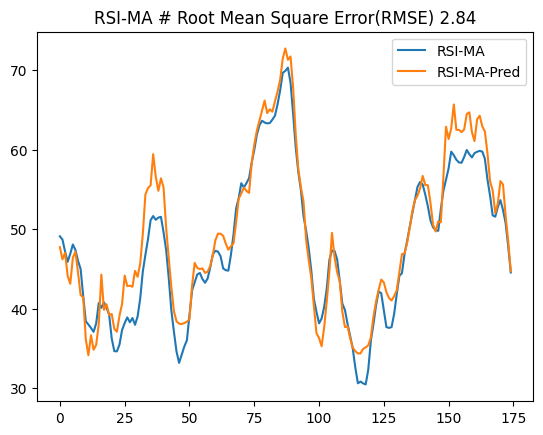

In [119]:
test_df=pd.DataFrame()
listColPair=[]
for i in range(0,len(my_features)): 
  dfActual=pd.DataFrame(data={my_features[i]:test_values[:,i]})  
  dfPred=pd.DataFrame(data={f'{my_features[i]}-Pred':y_test_pred[:,i]})
  listColPair.append([my_features[i],f'{my_features[i]}-Pred'])
  test_df=pd.concat([test_df,dfActual,dfPred],axis=1)
print(test_df.info())

#fig, axs = plt.subplots(nrows=len(listColPair), ncols=1, figsize=(14, 5*len(listColPair)))
for colPair in listColPair:
  rmse = np.sqrt(mean_squared_error(test_df[colPair[0]], test_df[colPair[1]]))
  title=f'{colPair[0]} # Root Mean Square Error(RMSE) {round(rmse,2)}'
  test_df[colPair].plot(title=title)
  plt.legend()
  plt.show()

# Predict One Value

In [120]:
print(f"We will use the last {n_input} data to predict the new one")
last_train_batch=train[-n_input:]
print(last_train_batch.shape,last_train_batch)

print("We need reshape first")
last_train_batch =last_train_batch .reshape((1,n_input,n_features))
print(last_train_batch.shape,last_train_batch)

print("Predict")
last_predict=model.predict(last_train_batch)
print(last_predict)

last_predict = scaler.inverse_transform(last_predict)
print(last_predict.shape,last_predict)


We will use the last 22 data to predict the new one
(22, 4) [[0.80451077 0.86232142 0.50465915 0.23071577]
 [0.79409869 0.8573104  0.49828347 0.23610146]
 [0.82519925 0.85585329 0.49632173 0.26963169]
 [0.85724945 0.85773687 0.50318784 0.29499653]
 [0.87573342 0.86129078 0.51839137 0.33443363]
 [0.88743429 0.86566209 0.54095145 0.3900278 ]
 [0.88699339 0.8695714  0.56743502 0.45066018]
 [0.90462947 0.87490227 0.59784208 0.49791522]
 [0.88499237 0.8777454  0.62726827 0.50990271]
 [0.90768187 0.88257872 0.65767533 0.52449618]
 [0.91514329 0.88769635 0.68906327 0.53648367]
 [0.9260641  0.89341815 0.72143207 0.55489924]
 [0.94519247 0.90049044 0.75527219 0.57314107]
 [0.93552654 0.90592793 0.787641   0.59763725]
 [0.91158216 0.90848674 0.8131437  0.58947186]
 [0.91592335 0.91118772 0.83374203 0.57974288]
 [0.92908258 0.9149904  0.85139774 0.57244614]
 [0.90951331 0.91644751 0.86365866 0.53874218]
 [0.8942174  0.91626981 0.86905346 0.50191105]
 [0.9018484  0.91683844 0.87052477 0.49027102]
